## Background

In this notebook I'll walk through an algorithm suggested by Claude to distinguish one typeface (like `display`) from another (like `serif`) in which we calculate the ratio of the number of corners to number of pixels in a text image.

This algorithm is part of my exploration of non-ML baselines to classify text images into various typeface categories (e.g., “humanist sans,” “grotesque sans,” “script,” “display,” etc.). Once the non-ML baseline is established, I'll train a neural network for this task. This is one of many notebooks in my [TypefaceClassifier project series](https://vishalbakshi.github.io/blog/#category=TypefaceClassifier).

In [1]:
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

## Load Image and Binarize It

As usual, we load the image and binarize it so it's easier to distinguish between background (black pixels) and text (white pixels).

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
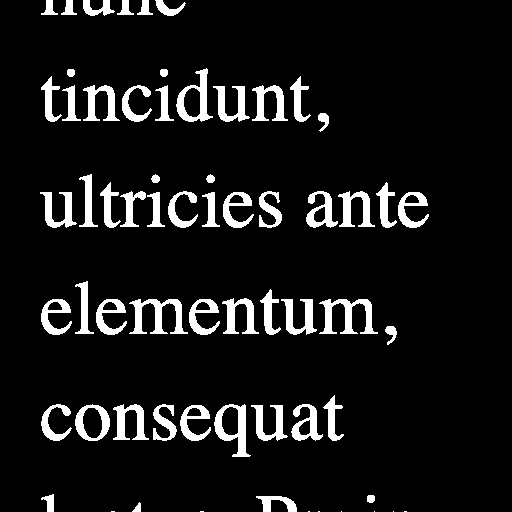

In [2]:
path = 'serif-76px.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

## Detect Corners

I'll use the [Harris Corner Detection algorithm](https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html) to identify the pixels at which there exists a corner in the image.

In [3]:
corners = cv2.cornerHarris(binary, blockSize=2, ksize=3, k=0.04)

Dilating the corners makes them brighter

In [4]:
corners = cv2.dilate(corners, None)

In [5]:
corners.shape

(512, 512)

In [6]:
corners[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

`threshold`ing the pixels so that pixels with a `corners` value above 1% of the maximum are set to white (255).

In [7]:
_, corners = cv2.threshold(corners, 0.01 * corners.max(), 255, 0)

The end result is a set of pixels that are the locations of corners in the image. Notice how the straight segments of the letters are (correctly) not identified as corners, while curves _are_ identified as corners.

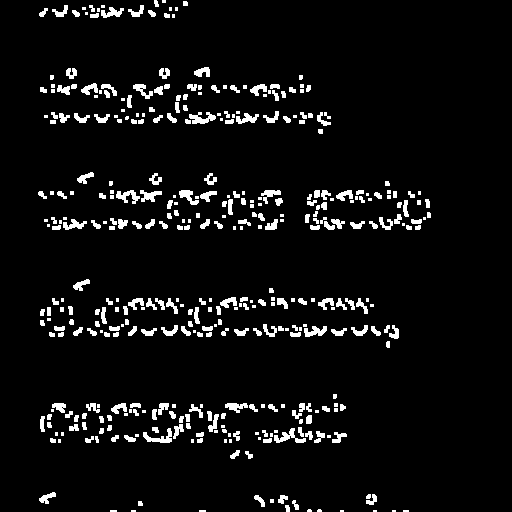

In [8]:
cv2_imshow(corners)

## Calculating the Ratio of Corner Pixels to Total Pixels

The number of corners are the number of `corners` pixels that have a value greater than `0`.

In [9]:
np.sum(corners > 0)

15127

The ratio of number of corners to pixels in an image is given as the ratio of the number of `corners` pixels greater than `0` divided by the number of `binary` pixels greater than `0`. In this case, 67% of the pixels represent corners.

In [10]:
np.sum(corners > 0), np.sum(binary > 0), np.sum(corners > 0) / np.sum(binary > 0)

(15127, 22475, 0.6730589543937708)

For a different image, notably `display` (sans serif) text of the same font-size (76px), this ratio is considerably smaller (39% < 67%).

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
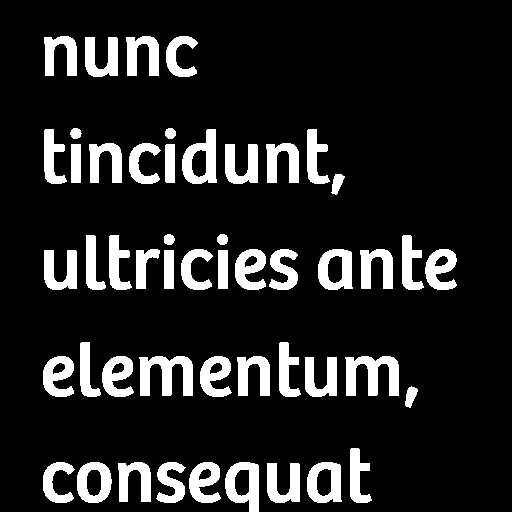

In [11]:
path = 'display-76px.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

In [12]:
corners = cv2.cornerHarris(binary, blockSize=2, ksize=3, k=0.04)
corners = cv2.dilate(corners, None)
_, corners = cv2.threshold(corners, 0.01 * corners.max(), 255, 0)
np.sum(corners > 0), np.sum(binary > 0), np.sum(corners > 0) / np.sum(binary > 0)

(13650, 34992, 0.3900891632373114)

Visually, you can see how much fewer corners are detected in this image than in the image with serif text---this makes sense! Serifs are intricate flourishes added to the ends of letters and contain more changes in stroke (corners).

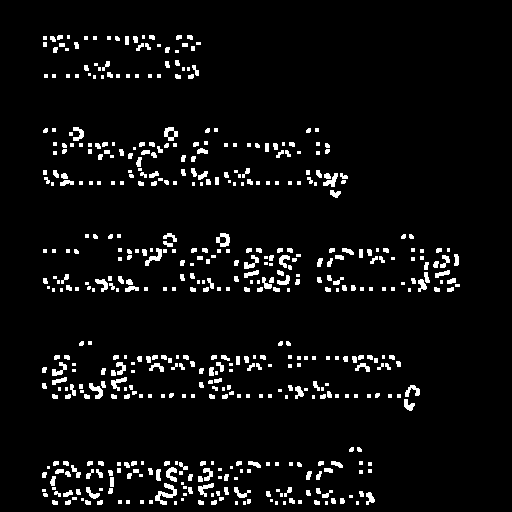

In [13]:
cv2_imshow(corners)

## Calculating Contour Ratio for Different Images

I'll now wrap the code above into a function and apply it to a wide variety of images (of two typefaces, `display` and `serif` and 8 different font sizes). I expect, on average, the `serif` images to have a higher corner ratio than `display` images, since serifs introduce more corners.

In [14]:
def corner_ratio(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    corners = cv2.cornerHarris(binary, blockSize=2, ksize=3, k=0.04)

    corners = cv2.dilate(corners, None)
    _, corners = cv2.threshold(corners, 0.01 * corners.max(), 255, 0)
    corners = np.uint8(corners)

    num_corners = np.sum(corners > 0)
    total_pixels = np.sum(binary > 0)

    corner_ratio = num_corners / total_pixels if total_pixels > 0 else 0

    return corner_ratio

On average, images with `serif` fonts have more corners present.

In [15]:
szs = [8, 18, 24, 36, 76, 240, 330, 420]
ts = ['display', 'serif']
res = []

for t in ts:
    for sz in szs:
        image_path = f"{t}-{sz}px.png"
        sr = corner_ratio(image_path)
        res.append([t, sz, sr])

res = pd.DataFrame(res, columns=['typeface', 'font-size', 'corner-ratio'])
res.groupby('typeface')['corner-ratio'].agg(['mean', 'median'])

,mean,median
typeface,,
display,0.989564,0.734144
serif,1.287083,1.134465


This trend holds up for each font size:

In [16]:
res.sort_values(by='font-size')

,typeface,font-size,corner-ratio
0,display,8,2.827288
8,serif,8,2.874287
1,display,18,1.784839
9,serif,18,2.573949
2,display,24,1.609162
10,serif,24,2.192324
3,display,36,1.078198
11,serif,36,1.595871
4,display,76,0.390089
12,serif,76,0.673059


## Final Thoughts

Similar to the [contour ratio algorithm](https://vishalbakshi.github.io/blog/posts/2024-09-06-typefaceclassifier-contour-ratio/) there is a clear and consistent difference in value between serif and sans serif fonts for this corner ratio algorithm, making this a good candidate for distinguishing between typefaces.

This is also another relatively simple algorithm, and each step can be easily visualized.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).